In [37]:



import os
import json
import logging
import random
import torch
import timm
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import datasets, transforms
from sklearn.metrics import auc
from tqdm.auto import tqdm

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Suppress warnings from the visualization library
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [38]:
CONFIG = {
    "data_path": "/content/uhar/data/data",
    "checkpoints_dir": "/content/drive/MyDrive/uhar/checkpoints/",
    "xai_results_dir": "/content/drive/MyDrive/uhar/xai_results/",
    "num_classes": 40,
    "image_size": 224,
    "models_to_explain": [
        "resnet18",
        "efficientnet_b0",
        "deit_tiny_distilled_patch16_224",
        "swin_tiny_patch4_window7_224"
    ]
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(CONFIG["xai_results_dir"], exist_ok=True)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', handlers=[logging.StreamHandler()])
logging.info(f"Using device: {DEVICE}")

# Unzip data if not already present
if not os.path.exists(CONFIG["data_path"]):
    !unzip -q "/content/archive (4).zip" -d "/content/uhar"

In [39]:
def create_test_dataset_pil(config):
    """Creates a test dataset that returns PIL images and handles class name inconsistencies."""
    data_transform = transforms.Compose([
        transforms.Resize((config["image_size"], config["image_size"])),
        transforms.Grayscale(num_output_channels=3),
    ])
    train_dir = os.path.join(config["data_path"], "characters_train_set")
    test_dir = os.path.join(config["data_path"], "characters_test_set")

    train_dataset_for_mapping = datasets.ImageFolder(train_dir)
    class_to_idx = train_dataset_for_mapping.class_to_idx
    class_names = train_dataset_for_mapping.classes

    # Load test set with a loader that returns PIL images
    test_dataset = datasets.ImageFolder(test_dir, loader=lambda x: Image.open(x).convert("RGB"))

    # Remap test set labels to match training set, handling case differences
    class_to_idx_lower = {k.lower(): v for k, v in class_to_idx.items()}
    valid_imgs = []
    for path, _ in test_dataset.imgs:
        class_name_from_folder = os.path.basename(os.path.dirname(path)).lower()
        correct_idx = class_to_idx_lower.get(class_name_from_folder)
        if correct_idx is not None:
            valid_imgs.append((path, correct_idx))

    test_dataset.imgs = valid_imgs
    test_dataset.samples = valid_imgs
    test_dataset.targets = [s[1] for s in valid_imgs]

    logging.info(f"Test dataset created with {len(test_dataset)} images across {len(class_names)} classes.")
    return test_dataset, class_names

test_dataset, class_names = create_test_dataset_pil(CONFIG)

In [40]:
@torch.no_grad()
def get_model(model_name, config):
    """loads a trained model from a checkpoint and sets it to evaluation mode."""
    checkpoint_path =  f"{model_name}_best_model.pth"
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found for {model_name} at {checkpoint_path}")

    model = timm.create_model(model_name, pretrained=False, num_classes=config["num_classes"])
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    model.eval()
    return model.to(DEVICE)

CNN_TARGET_LAYERS = {
    "resnet18": lambda m: m.layer4[-1],
    "resnet50": lambda m: m.layer4[-1],
    "mobilenetv2_100": lambda m: m.conv_head,
    "efficientnet_b0": lambda m: m.conv_head
}

# Define the preprocessing transform for model input
preprocess_transform = transforms.Compose([
    transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [41]:
def generate_grad_cam(model, image_tensor, target_layer_fn):
    """Generates a Grad-CAM heatmap and predicted class index for a CNN model."""
    target_layer = target_layer_fn(model)
    cam = GradCAM(model=model, target_layers=[target_layer])

    with torch.no_grad():
        target_category = model(image_tensor).argmax(dim=1).item()

    targets = [ClassifierOutputTarget(target_category)]
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0, :]
    return grayscale_cam, target_category

def generate_attention_rollout(model, image_tensor):
    """Generates an attention rollout map and predicted class index for a ViT model."""
    with torch.no_grad():
        target_category = model(image_tensor).argmax(dim=1).item()

    attentions = []
    hooks = [
        block.attn.attn_drop.register_forward_hook(lambda module, input, output: attentions.append(output))
        for block in model.blocks
    ]

    with torch.no_grad():
        model(image_tensor)
    for hook in hooks:
        hook.remove()

    result = torch.eye(attentions[0].shape[-1], device=DEVICE)
    for attention in attentions:
        attention_heads_fused = attention.mean(axis=1)
        I = torch.eye(attention_heads_fused.shape[-1], device=DEVICE)
        a = (attention_heads_fused + I) / 2
        a = a / a.sum(dim=-1, keepdim=True)
        result = torch.matmul(a, result)

    mask = result[0, 0, 1:]
    grid_size = int(np.sqrt(mask.shape[-1]))
    mask = mask.reshape(grid_size, grid_size).cpu().numpy()
    mask = cv2.resize(mask, (CONFIG["image_size"], CONFIG["image_size"]))
    return mask / mask.max(), target_category

In [45]:
def calculate_deletion_auc(model, image_tensor, explanation_map, true_class_idx):
    """Calculates the Deletion Area Under the Curve (AUC). Lower is better."""
    num_pixels = image_tensor.shape[-2] * image_tensor.shape[-3]
    flat_map = explanation_map.flatten()
    sorted_indices = np.argsort(flat_map)[::-1]

    image_flat = image_tensor.clone().cpu().flatten().numpy() # Convert to numpy array
    confidences = []

    with torch.no_grad():
        initial_prob = F.softmax(model(image_tensor), dim=1)[0, true_class_idx].item()
    confidences.append(initial_prob)

    steps = np.linspace(0, num_pixels - 1, num=21, dtype=int)
    for num_to_delete in steps[1:]:
        img_copy_flat = image_flat.copy() # Use numpy copy
        img_copy_flat[sorted_indices[:num_to_delete]] = 0
        # Convert back to tensor, reshape, and move to device
        img_tensor = torch.from_numpy(img_copy_flat).reshape_as(image_tensor.cpu()).to(DEVICE)

        with torch.no_grad():
            prob = F.softmax(model(img_tensor), dim=1)[0, true_class_idx].item()
        confidences.append(prob)

    x_axis = np.linspace(0, 1, len(confidences))
    return auc(x_axis, confidences)

In [46]:
from io import BytesIO; from PIL import ImageFilter
def add_gaussian_noise(img, sigma):
  arr = np.array(img).astype(np.float32)
  noise = np.random.normal(0, sigma, arr.shape)
  return Image.fromarray(np.clip(arr + noise, 0, 255).astype(np.uint8))
def add_salt_and_pepper(img, prob): arr = np.array(img).copy(); h, w = arr.shape[:2]; num = int(h*w*prob); [np.put(arr, [np.random.randint(0,h), np.random.randint(0,w), i], 0 if random.random()<0.5 else 255) for i in range(arr.shape[2])] if arr.ndim == 3 else [np.put(arr, [np.random.randint(0,h), np.random.randint(0,w)], 0 if random.random()<0.5 else 255) for _ in range(num)]; return Image.fromarray(arr)
def motion_blur(img, radius):
  return img.filter(ImageFilter.GaussianBlur(radius=radius))


def find_case_study_image(robust_model, fragile_model, corruption_fn, severity, test_dataset, max_tries=500):
    """Finds an image that the robust model gets right and the fragile model gets wrong."""
    logging.info(f"Searching for case study: Robust={robust_model.name}, Fragile={fragile_model.name}...")

    for i in range(max_tries):
        pil_img, true_idx = random.choice(test_dataset.samples)

        corrupted_pil = corruption_fn(pil_img, severity)
        corrupted_tensor = preprocess_transform(corrupted_pil).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            robust_pred = robust_model(corrupted_tensor).argmax().item()
            fragile_pred = fragile_model(corrupted_tensor).argmax().item()

        if robust_pred == true_idx and fragile_pred != true_idx:
            logging.info(f"Found suitable image at index {i} for class '{class_names[true_idx]}'.")
            return pil_img, corrupted_pil, true_idx

    logging.warning("Could not find a suitable case study image after many tries.")
    return None, None, None

ValueError: operands could not be broadcast together with shapes (224,224,3) (28,28,3) 

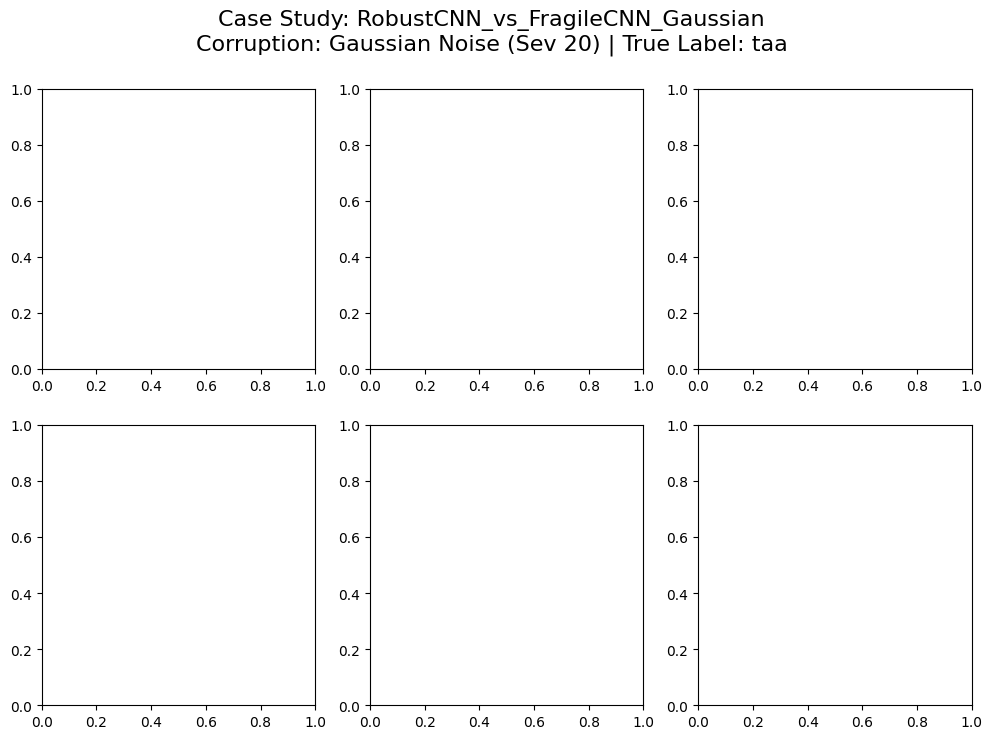

In [49]:
all_results = []
models_loaded = {name: get_model(name, CONFIG) for name in CONFIG["models_to_explain"]}

case_studies = {
    "RobustCNN_vs_FragileCNN_Gaussian": {
        "robust": "resnet18", "fragile": "efficientnet_b0", "models_to_show": ["resnet18", "efficientnet_b0"],
        "corruption_fn": add_gaussian_noise, "severity": 20, "corruption_info": "Gaussian Noise (Sev 20)"
    },
    "RobustViT_vs_FragileCNN_SaltPepper": {
        "robust": "deit_tiny_distilled_patch16_224", "fragile": "efficientnet_b0", "models_to_show": ["deit_tiny_distilled_patch16_224", "efficientnet_b0"],
        "corruption_fn": add_salt_and_pepper, "severity": 0.06, "corruption_info": "Salt & Pepper (Sev 0.06)"
    },
    "MotionBlur_Specialist_vs_Generalist": {
        "robust": "swin_tiny_patch4_window7_224", "fragile": "resnet18", "models_to_show": ["swin_tiny_patch4_window7_224", "resnet18"],
        "corruption_fn": motion_blur, "severity": 15, "corruption_info": "Motion Blur (Sev 15)"
    }
}

def find_case_study_image(robust_model_name, fragile_model_name, robust_model, fragile_model, corruption_fn, severity, test_dataset, max_tries=500):
    """Finds an image that the robust model gets right and the fragile model gets wrong."""
    logging.info(f"Searching for case study: Robust={robust_model_name}, Fragile={fragile_model_name}...")

    for i in range(max_tries):
        image_path, true_idx = random.choice(test_dataset.samples)
        pil_img = Image.open(image_path).convert("RGB") # Load the image from the path

        corrupted_pil = corruption_fn(pil_img, severity)
        corrupted_tensor = preprocess_transform(corrupted_pil).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            robust_pred = robust_model(corrupted_tensor).argmax().item()
            fragile_pred = fragile_model(corrupted_tensor).argmax().item()

        if robust_pred == true_idx and fragile_pred != true_idx:
            logging.info(f"Found suitable image for class '{class_names[true_idx]}'.")
            return pil_img, corrupted_pil, true_idx

    logging.warning("Could not find a suitable case study image after many tries.")
    return None, None, None


for name, params in case_studies.items():
    robust_model = models_loaded[params["robust"]]
    fragile_model = models_loaded[params["fragile"]]

    clean_pil, corrupted_pil, true_idx = find_case_study_image(
        params["robust"], params["fragile"], robust_model, fragile_model,
        params["corruption_fn"], params["severity"], test_dataset
    )
    if not clean_pil: continue

    clean_tensor = preprocess_transform(clean_pil).unsqueeze(0).to(DEVICE)
    corrupted_tensor = preprocess_transform(corrupted_pil).unsqueeze(0).to(DEVICE)

    fig, axes = plt.subplots(len(params["models_to_show"]), 3, figsize=(12, 4 * len(params["models_to_show"])))
    fig.suptitle(f"Case Study: {name}\nCorruption: {params['corruption_info']} | True Label: {class_names[true_idx]}", fontsize=16)

    for i, model_name in enumerate(params["models_to_show"]):
        model = models_loaded[model_name]

        if model_name in CNN_TARGET_LAYERS:
            corrupted_map, corrupted_pred_idx = generate_grad_cam(model, corrupted_tensor, CNN_TARGET_LAYERS[model_name])
        else:
            corrupted_map, corrupted_pred_idx = generate_attention_rollout(model, corrupted_tensor)

        # Resize heatmap to image size
        resized_corrupted_map = cv2.resize(corrupted_map, (CONFIG["image_size"], CONFIG["image_size"]))

        # Compute metrics and store
        del_auc = calculate_deletion_auc(model, corrupted_tensor, corrupted_map, true_idx) # Use original map for AUC
        all_results.append({"Case": name, "Model": model_name, "Deletion AUC": del_auc, "Correct": class_names[corrupted_pred_idx] == class_names[true_idx]})

        # Visualize
        overlay = show_cam_on_image(np.array(corrupted_pil)/255.0, resized_corrupted_map, use_rgb=True) # Use resized map for visualization
        axes[i, 0].imshow(corrupted_pil)
        axes[i, 0].set_title(f"Model: {model_name}\nCorrupted Input")
        axes[i, 1].imshow(resized_corrupted_map, cmap='jet') # Use resized map for visualization
        axes[i, 1].set_title("Saliency Map")
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title(f"Overlay\nPredicted: {class_names[corrupted_pred_idx]}")
        for ax in axes[i]: ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.savefig(os.path.join(CONFIG["xai_results_dir"], f"XAI_{name}.png"), dpi=300)
    plt.show()

In [ ]:
results_df = pd.DataFrame(all_results)
pivot_df = results_df.pivot_table(index="Case", columns="Model", values=["Deletion AUC", "Correct"])

print("\n" + "="*80)
print("           Quantitative Explainability Summary (On Corrupted Images)")
print("="*80)
print("\n--- Explanation Fidelity (Deletion AUC - Lower is Better) ---")
print(pivot_df["Deletion AUC"].to_string(float_format="%.4f"))
print("\n--- Model Correctness on Selected Image ---")
print(pivot_df["Correct"])
print("="*80)

# Save the results to a CSV file
pivot_df.to_csv(os.path.join(CONFIG["xai_results_dir"], "quantitative_xai_summary.csv"))